In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pythonpackage.computation import correlation
from notebookstyle import css_styling
%matplotlib inline
css_styling()

### Reading the trajectory file

In [2]:
file = 'Trajectories/spce300K_NVE_reduced.h5'

with h5py.File(file, 'r') as f:
    time = np.copy(f['time'])
    box_size = np.copy(f['box_size'])
    coordinates = np.copy(f['coordinates'])
    natoms = f['natoms'][0]

In [3]:
nmolecules = natoms // 3

In the following, we assume that the box is cubic and constant in time, and therefore characterized by a single parameter $L$. Here we check that this assumption is true for the data we have.

In [4]:
l = np.unique(box_size)
assert l.shape == (1,)
l = l[0]

### Computation of the weights

The order of the atoms is O, H1, H2 for each water molecule. The scattering lengths are $b_{coh}^{(O)} = 5.805 fm$ and $b_{coh}^{(H)} = -3.741 fm$. We compute the normalized weights $w_{coh}$ from these values.

In [5]:
b_O = 5.805
b_H = -3.741
w = np.array(nmolecules*[b_O, b_H, b_H])
w /= np.sqrt(np.sum(w**2))

### Iteration over $q$ vectors

We compute $F_{coh}(q, t)$ in an interval $[q_{min}, q_{max}]$, where $q_{min}$ is defined by the box size:

  $$ q_{min} = \frac{2\pi}{L} $$

The parameter $q_{max}$ can be freely chosen. We then generate all $q$ vectors whose $x$, $y$, and $z$ components are integer multiples of $q_{min}$. Since $F_{coh}(q, t) = F_{coh}(-q, t)$, we limit ourselves to $q_z \geq 0$.

In [24]:
def q_vectors(q_min, q_max):
    n_max = int(q_max/q_min)
    for nx in np.arange(-n_max, n_max+1):
        for ny in np.arange(-n_max, n_max+1):
            for nz in np.arange(0, n_max+1):
                if nx == 0 and ny == 0 and nz == 0:
                    continue
                qv = np.array([nx, ny, nz])*q_min
                qv_length = np.sqrt(np.dot(qv, qv))
                if qv_length <= q_max:
                    yield qv, qv_length

In [33]:
q_min = 2.*np.pi/l
q_max = 7.*q_min

In [34]:
sq = []
qv_counter = {}

for qv, qv_length in q_vectors(q_min, q_max):
    qv_counter[qv_length] = qv_counter.get(qv_length, 0) + 1
    rho = np.sum(w * np.exp(-1j*np.dot(coordinates, qv)), axis=1)
    f = correlation(rho)

    sq.append((qv_length, f[0]))

sq = np.array(sq)

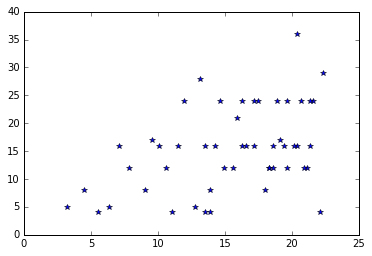

In [35]:
qv_counter = np.array(list(qv_counter.items()))
plt.plot(qv_counter[:, 0], qv_counter[:, 1], "b*")

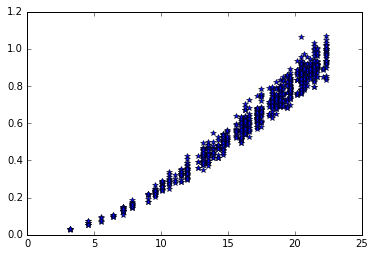

In [36]:
plt.plot(sq[:, 0], sq[:, 1],  "b*")

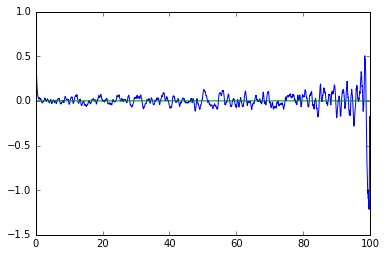

In [37]:
plt.plot(time, f.real)
plt.plot(time, f.imag)